In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from umap import UMAP



sns.set_theme(style="whitegrid")

## **Importing data**

In [ ]:
# Import main data frame
df = pd.read_json("data/nlp-chatbot-analysis_data/training-set/chatbot-arena-conversations.jsonl.gz",
                  compression='gzip',
                  lines=True)
df.head(1)

In [ ]:
# Auxiliary Datasets

# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-model_b_response-embeddings.npy"
)

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
     "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-gpt3-scores.jsonl.gz",
     lines=True,
     compression="gzip"
)

topic_and_hardness.head(1)

In [ ]:
# Import main test data
df_test = pd.read_json("data/nlp-chatbot-analysis_data/test-set/arena-test-set-topic-modeling.jsonl.gz",
                  compression='gzip',
                  lines=True)
df_test.head(1)

test_prompts = pd.read_json("data/nlp-chatbot-analysis_data/test-set/arena-test-set-prompt-and-responses.jsonl.gz",
                  compression='gzip',
                  lines=True)

In [ ]:
# Test embedding Data -- we will use this data in the "Embedding Data" section
test_response_a_embeddings = np.load(
    "data/nlp-chatbot-analysis_data/test-set/arena-test-set-model_a_response-embeddings.npy"
)

test_response_b_embeddings = np.load(
    "data/nlp-chatbot-analysis_data/test-set/arena-test-set-model_b_response-embeddings.npy"
)

test_prompt_embeddings = np.load(
    "data/nlp-chatbot-analysis_data/test-set/arena-test-set-prompts-embeddings.npy"
)

## **Data Cleaning**

In [ ]:
# If below throws error, run this cell:
# response_a_embeddings = np.delete(response_a_embeddings, all_removed_idx)
# response_b_embeddings = np.delete(response_b_embeddings, all_removed_idx)
# prompt_embeddings = np.delete(prompt_embeddings,all_removed_idx)

In [ ]:
# Add embeddings to df
df["prompt_embedding"] = list(prompt_embeddings)
df["model_a_response_embedding"] = list(response_a_embeddings)
df["model_b_response_embedding"] = list(response_b_embeddings)

#print(df.head(2))
#print(prompt_embeddings[:2])

In [ ]:
# Extract prompts and prompt lengths
df["prompt"] = df["conversation_a"].str[0].str["content"]
df["prompt_length"] = df["prompt"].str.len()

In [ ]:
# Extract model a and b responses and their lengths
df["model_a_response"] = df["conversation_a"].str[1].str["content"]
df["model_a_response_length"] = df["model_a_response"].str.len()

df["model_b_response"] = df["conversation_b"].str[1].str["content"]
df["model_b_response_length"] = df["model_b_response"].str.len()

In [ ]:
# Generate response similarity matrix and then add a column that gives the similarities of each response in the dataframe
# Doing this here as it becomes harder once the unsalvagable rows are dropped
response_similarities = cosine_similarity(response_a_embeddings, response_b_embeddings)
df['response_similarity'] = response_similarities.diagonal()

In [ ]:
# Removing 10 duplicates from df

dupes = df['question_id'].duplicated(keep='first')

# Get indices of duplicates
dropped_indices = df['question_id'][dupes].index.tolist()

# Drop duplicates
df = df.drop_duplicates(subset=['question_id'], keep='first')
print(len(df))

print("Dropped indices:", dropped_indices)

In [ ]:
# Remove any duplicates from topic_and_hardess
topic_and_hardness = topic_and_hardness.drop_duplicates(subset=['question_id'])

In [ ]:
# Function to clean topic_and_hardness
def cleanLists(df):
    count = [1, 2, 3]

    for num in count:
        # replacing list values in topics
        df[f'topic_modeling_{num}'] = np.where(df[f'topic_modeling_{num}'].apply(lambda x: isinstance(x, list)),
                                              ','.join(map(str, df[f'topic_modeling_{num}'])), # If found to be list, replace with string
                                               df[f'topic_modeling_{num}'] # else, keep value as is
                                              )

        # replacing nested list values in score value
        df[f'score_value_{num}'] = np.where(df[f'score_value_{num}'].apply(lambda x: isinstance(x, list)),
                                           df[f'score_value_{num}'][0], # if found to be list, replace with nested value
                                           df[f'score_value_{num}']) # else, keep value

    return df

In [ ]:
# Function to clean topic_and_hardness
def cleanLists2(df):
    count = [1, 2, 3]

    for num in count:
        # replacing list values in topics
        df[f'topic_modeling_{num}'] = np.where(df[f'topic_modeling_{num}'].apply(lambda x: isinstance(x, list)),
                                              ','.join(map(str, df[f'topic_modeling_{num}'])), # If found to be list, replace with string
                                               df[f'topic_modeling_{num}'] # else, keep value as is
                                              )
    return df

In [ ]:
# Clean t&h
topic_and_hardness = cleanLists(topic_and_hardness)

# converting floats to integer values
topic_and_hardness.loc[23757, 'score_value_1'] = int(topic_and_hardness.loc[23757, 'score_value_1'] * 10)
topic_and_hardness.loc[23757, 'score_value_3'] = int(topic_and_hardness.loc[23757, 'score_value_3'] * 10)

In [ ]:
# Extract salvageable rows based on parsing through raw data
salvagable_null_rows = topic_and_hardness.loc[[10857, 15368, 20363, 24966],:]

In [ ]:
# Dropna from topic and hardness, and use rest to salvagable df and topic and hardness df seperately to extract topics
removed_na = []
for index in topic_and_hardness[topic_and_hardness['topic_modeling_1'].isna()].index:
    if index not in salvagable_null_rows.index:
        removed_na.append(index)
topic_and_hardness = topic_and_hardness.dropna()

In [ ]:
# Creating a df copy for classification task that keeps response similarity scores
class_df = df.copy()

# dropping 'response_similarity' from main df
df = df.drop(columns=['response_similarity'])

In [ ]:
all_removed_idx = dropped_indices + removed_na

# General Feature Engineering
Features to be used across modeling tasks

In [ ]:
# All Topic Extraction Tasks
topic_regex = r'\"topic_modeling":\s"([\w\W]+?)\"'
new_raw_choices = salvagable_null_rows.loc[:,'openai_scores_raw_choices_nested'].astype('str')
salvaged_topics = new_raw_choices.str.findall(pat=topic_regex)
salvaged_topics = pd.DataFrame(salvaged_topics)
salvaged_topics.rename(columns = {'openai_scores_raw_choices_nested':'topics'},
                       inplace=True)
salvaged_topics['topics'] = salvaged_topics['topics'].str.join(', ')

# Creating raw topics dataframe
raw_topics = topic_and_hardness['question_id']
raw_topics = pd.DataFrame(raw_topics)
raw_topics['topics'] = topic_and_hardness['topic_modeling_1'] + ', ' + topic_and_hardness['topic_modeling_2'] + ', ' + topic_and_hardness['topic_modeling_3']

all_topics = pd.concat([raw_topics, salvaged_topics])
all_topics = all_topics.sort_index()
all_topics = all_topics.drop(columns=['question_id'])
all_topics.head(5)

In [ ]:
def extractTestTopics(df_test):
    """
    Extract topics from test df
    """
    test_topic_embeddings = df_test.copy()
    test_topic_embeddings = cleanLists2(test_topic_embeddings)
    test_topic_embeddings['topics'] = test_topic_embeddings['topic_modeling_1'] + ', ' + test_topic_embeddings['topic_modeling_2'] + ', ' + test_topic_embeddings['topic_modeling_3'] 


    element_types = test_topic_embeddings['topics'].map(type)
    rows_to_impute = test_topic_embeddings[test_topic_embeddings['topics'].map(lambda x: isinstance(x, float))].index

    imputed_topic = test_topic_embeddings.loc[139,'topics']
    
    # Imputing Blank Rows with Topics
    test_topic_embeddings.loc[rows_to_impute,'topics'] = imputed_topic

    return test_topic_embeddings['topics']

In [ ]:
def generateTopicEmbeddings(train_topics, df_test):
    """
    Return reduced embeddings for train and test topics
    """
    test_topics = extractTestTopics(df_test)
    
    # Check if MPS is available
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
    print(f"Using device: {device}")
    
    # Load model
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)

    # Topic Embeddings
    train_topic_embeddings = []
    for topic in train_topics['topics']:
        embedding = model.encode(topic)
        train_topic_embeddings.append(embedding)

    # Test Embeddings
    test_topic_embeddings = []
    for topic in test_topics:
        embedding = model.encode(topic)
        test_topic_embeddings.append(embedding)
    

    # Convert embeddings to numpy array 
    train_embeddings_array = np.array(train_topic_embeddings)
    test_embeddings_array = np.array(test_topic_embeddings)
    
    # Define UMAP model 
    umap_model = UMAP(n_neighbors=25, 
                     n_components=10,  
                     min_dist=0.0,
                     metric='cosine',
                     random_state=42)
    
    # Fit and transform the embeddings
    train_topic_embeddings_reduced = umap_model.fit_transform(train_embeddings_array)
    test_topic_embeddings_reduced = umap_model.fit_transform(test_embeddings_array)

    return train_topic_embeddings_reduced, test_topic_embeddings_reduced


In [ ]:
# FOR PROMPT EMBEDDINGS
test_matrix = test_prompt_embeddings

# Clustering embeddings
k = 50
k_means = KMeans(n_clusters=k,
               random_state=42)
test_cluster_labels = k_means.fit_predict(test_matrix)

In [ ]:
df_test['cluster_label'] = test_cluster_labels

In [ ]:
train_topic_embeddings, test_topic_embeddings = generateTopicEmbeddings(all_topics, df_test)

# **Task A**

Workspace for winner-determination stuff

## Initial Data Preparation
* Here we begin preparing the class_df, which is our raw dataset that will be used during train/validation. And will make up the raw data for what will train our final test model

In [ ]:
# Absolute Response Length Difference
class_df['response_length_difference'] = np.absolute(class_df['model_a_response_length'] - class_df['model_b_response_length'])

In [ ]:
# Fixing skew with log transforms
class_df['log_prompt_length'] = np.log(class_df['prompt_length'])

In [ ]:
# changing some column names
class_df.rename(columns={'model_a_response':'response_a','model_b_response': 'response_b',
                         'model_a_response_length':'response_a_length',
                         'model_b_response_length':'response_b_length'}, inplace=True)

In [ ]:
# Score Stuff

# Extract topics from salvagable null rows:
score_regex = r'\"score_value\":\s(\d)+'
# Salvagable raw choices used above in topic_extraction
salvagable_raw_choices = salvagable_null_rows.loc[:,'openai_scores_raw_choices_nested'].astype('str')


salvagable_raw_scores = salvagable_raw_choices.str.findall(pat=score_regex)

# Converting strings to ints then taking means
for index in salvagable_raw_scores.index:
    salvagable_raw_scores[index] = [int(item) for item in salvagable_raw_scores[index]]
    salvagable_raw_scores[index] = np.mean(salvagable_raw_scores[index])

salvagable_raw_scores.name = 'avg_hardness_score'

# Average of scores from topic_and_hardness
score_values_core = ((topic_and_hardness['score_value_1'] + topic_and_hardness['score_value_2'] + topic_and_hardness['score_value_3'])/3).astype('int')

# Concatenation of all _scores
all_scores = pd.concat([salvagable_raw_scores, score_values_core])
all_scores = pd.Series(all_scores, name='avg_hardness_score')

In [ ]:
# Add average scores to class_df
class_df['hardness_score'] = all_scores

### Bradley Terry Modeling
* Here we extract Bradley Terry scores for use in our logistic regression classifier

In [ ]:
# BT Implementation with Helper Functions
def btNumerator(skill_levels, df, current_model):
    """
    Helper Function. Returns the numerator for a Bradley-Terry Calculation per wikipedia equation 5
    """
    numerator_outcome = 0
    combatting_models = df.index
    model_a_skill = skill_levels.loc[current_model]

    # performing the summation here
    for i in range(len(df)):
        # row denotes model a wins against model b. Use iloc because we are using the index location of each model, not label
        model_a_wins = df.iloc[i]

        model_b_skill = skill_levels.loc[combatting_models[i]]

        calculation = model_a_wins*(model_b_skill/(model_a_skill+model_b_skill))
        numerator_outcome += calculation

    return numerator_outcome


def btDenominator(skill_levels, df, current_model):
    """
    Helper Function. Returns the denominator for a Bradley-Terry Calculation per wikipedia equation 5
    """
    denominator_outcome = 0
    combatting_models = df.index
    model_a_skill = skill_levels.loc[current_model]

    # performing the summation here
    for i in range(len(df)):
        # row here denotes model b wins against model a. Use iloc because we are using the index location of each model, not label
        model_b_wins = df.iloc[i]

        model_b_skill = skill_levels.loc[combatting_models[i]]

        calculation = model_b_wins*(1/(model_a_skill+model_b_skill))
        denominator_outcome += calculation

    return denominator_outcome

def bradleyTerry(df, skill_levels, max_iterations=1000):
    """
    My implementation of bradley-terry based off of the algorithm on wikipedia. Specifically
    The algorithm which is noted to reach "convergence" faster. Will return a new list
    of skill_levels for each model, and run until convergence is met (set at when all skill levels < 1e-8)
    or until max iterations is reached (set at 1000)
    """
    # Will run until convergence condition is met, which is when new_skill_levels < 1e-8 for all models
    iterations = 0
    threshold_flag = False
    while (threshold_flag == False) and (max_iterations != iterations):
        # Creating a temporary list that we will use to compare against old values
        new_skill_levels = []

        # update parameters, process repeats until all parameters meet the condition of |new_skill_level - olc_skill_level| < threshold
        for current_model, model_pairs in df.iterrows():
            # For the numerator, I just need all columns pertaining to other models
            numerator = btNumerator(skill_levels, df.loc[current_model, df.index[df.index != current_model]], current_model)

            # for the denominator, I need all rows pertaining to other models for the current model column
            denominator = btDenominator(skill_levels, df.loc[df.index[df.index != current_model], current_model], current_model)

            new_skill_level = numerator/denominator

            # update the relevant parameter
            new_skill_levels.append(new_skill_level)

        # convert new_skill_levels into series for vector wise operations
        new_skill_levels = pd.Series(new_skill_levels, index=skill_levels.index)

        # Normalize all parameters by geometric mean:
        geometric_mean = (np.prod(new_skill_levels))**(1/skill_levels.shape[0])

        new_skill_levels = new_skill_levels/geometric_mean

        # confirm threshold is not met, if so, continue calculating BT for all models. .all returns true when entire series is true. If true, convergence
        # met
        if (np.abs(new_skill_levels-skill_levels) < 1e-8).all():
            skill_levels = new_skill_levels
            threshold_flag = True
        else:
            skill_levels = new_skill_levels
        iterations += 1
    print(f"Finding BT took {iterations} operations until convergence")
    return skill_levels

In [ ]:
# Creating a sub dataframe of all model pairings in the dataset
model_pairings = df[['model_a', 'model_b', 'winner']]

# Surpressing warnings for style
warnings.simplefilter('ignore')

# Making indicator column of a victory by model pairing to create pairwise
# comparison matrix
model_pairings['winning_model'] = model_pairings.apply(lambda x: x[x['winner']] if x['winner'] != 'tie' and x['winner'] != 'tie (bothbad)' else 0, axis=1)
model_pairings['model_a_win'] = model_pairings.apply(lambda x: 1 if x['winning_model'] == x['model_a'] else 0, axis=1)
model_pairings['model_b_win'] = model_pairings.apply(lambda x: 1 if x['winning_model'] == x['model_b'] else 0, axis=1)

In [ ]:
# Creating pairwise win matrixes, two iterations then adding both to full gaps
pairwise_win_matrix_a = model_pairings.pivot_table(
    index='model_a',
    columns='model_b',
    values='model_a_win',
    aggfunc= 'sum'
)
pairwise_win_matrix_b = model_pairings.pivot_table(
    index='model_b',
    columns='model_a',
    values='model_b_win',
    aggfunc= 'sum'
)
true_pairwise_win_matrix = pairwise_win_matrix_a + pairwise_win_matrix_b

In [ ]:
# Now to calculate bradley-terry scores:
# initializing model_scores
init_model_skill_levels = pd.Series(np.ones(true_pairwise_win_matrix.shape[0]), index=true_pairwise_win_matrix.index)

In [ ]:
# Scoring models with BT
bt_model_skill_levels = bradleyTerry(true_pairwise_win_matrix, init_model_skill_levels)

In [ ]:
# Sorting by values descending and comparing to rankings we found with elo for sanity check
bt_model_skill_levels.sort_values(ascending=False)

In [ ]:
# adding model bt scores to dataset. Creating as function so it can be used to transform test set later
def btAllocate(df, mapping):
    df['model_a_skill'] = df['model_a'].map(mapping)
    df['model_b_skill'] = df['model_b'].map(mapping)
    df['pr_model_a_win'] = df['model_a_skill'] / (df['model_a_skill'] + df['model_b_skill'])
    df['pr_model_b_win'] = df['model_b_skill'] / (df['model_a_skill'] + df['model_b_skill'])

    return df

In [ ]:
class_df = btAllocate(class_df, bt_model_skill_levels.to_dict())

### Feature Engineering Additional
* A bit messy, this is where we explore additional potential features

#### Transformations

In [ ]:
# Experimenting with normalizing transformations
plt.figure(figsize=(10, 6))
sns.histplot((class_df['response_similarity'])**3, kde=True)

In [ ]:
class_df['res_sim_cubed'] = (class_df['response_similarity'])**3

In [ ]:
sns.histplot(np.cbrt(class_df['response_a_length']), kde=True)
plt.ylabel('Count')
plt.xlabel('Cube Root of Response Length (Model A)')

In [ ]:
sns.histplot(np.cbrt(class_df['response_b_length']), kde=True)

In [ ]:
sns.histplot(np.log(class_df['prompt_length']), kde=True)

In [ ]:
class_df['cube_a_length'] = np.cbrt(class_df['response_a_length'])
class_df['cube_b_length'] = np.cbrt(class_df['response_b_length'])

In [ ]:
sns.histplot((class_df['pr_model_b_win']), kde=True)

#### Creating Response to Prompt Similarities

In [ ]:
# Response to Prompt similarity
response_a_similarities = cosine_similarity(response_a_embeddings, prompt_embeddings)
response_b_similarities = cosine_similarity(response_b_embeddings, prompt_embeddings)

In [ ]:
response_a_similarities = np.delete(response_a_similarities, removed_na, axis=0)
response_a_similarities = np.delete(response_a_similarities, removed_na, axis=1)

response_b_similarities = np.delete(response_b_similarities, removed_na, axis=0)
response_b_similarities = np.delete(response_b_similarities, removed_na, axis=1)

In [ ]:
response_a_similarities = np.delete(response_a_similarities, dropped_indices, axis=0)
response_a_similarities = np.delete(response_a_similarities, dropped_indices, axis=1)

response_b_similarities = np.delete(response_b_similarities, dropped_indices, axis=0)
response_b_similarities = np.delete(response_b_similarities, dropped_indices, axis=1)

In [ ]:
response_a_similarities.shape

In [ ]:
#Drop additional na if not removed yet
class_df.dropna(inplace=True)

In [ ]:
# Assign response to prompt similarities
class_df['response_a_prompt_similarity'] = response_a_similarities.diagonal()
class_df['response_b_prompt_similarity'] = response_b_similarities.diagonal()

In [ ]:
sns.histplot((class_df['response_a_prompt_similarity'])**3, kde=True)

In [ ]:
sns.histplot((class_df['response_b_prompt_similarity'])**3, kde=True)
plt.xlabel('Cosine Similarity of Response B to Prompts Cubed')

In [ ]:
# Assign transformed response similarities
class_df['rpSim_a_cubed'] = (class_df['response_a_prompt_similarity'])**3
class_df['rpSim_b_cubed'] = (class_df['response_b_prompt_similarity'])**3

#### Code for Elo
* This feature largely goes unused, but we keep to show our work

In [ ]:
# Adding ELO (Sonja Code)
# Code for ELO rating
def calc_elo(ratings, A, B, winner):
    RA = ratings[A]
    RB = ratings[B]
    #w = ratings[winner]

    EA = 1.0 / (1.0 + 10.0**((RB - RA)/400.0))
    EB = 1.0 / (1.0 + 10.0**((RA - RB)/400.0))

    if winner == 'model_a':
        SA, SB = 1.0, 0.0
    elif winner == 'model_b':
        SA, SB = 0.0, 1.0
    else:
        SA, SB = 0.5, 0.5

    ratings[A] = RA + 32.0 * (SA - EA)
    ratings[B] = RB + 32.0 * (SB - EB)

    return ratings

def get_updated_elo(ratings, matches):
    num_matches = len(matches)
    for i in range(num_matches):
        A, B, winner = matches.iloc[i,0], matches.iloc[i,1], matches.iloc[i,2]
        ratings = calc_elo(ratings, A, B, winner)
    return ratings

def make_ELO_list(x):
    '''
    Should return a len 20 list with the corresponding ratings for each model
    '''
    matches = x[['model_a', 'model_b', 'winner']]
    models_list = ['chatglm-6b', 'oasst-pythia-12b', 'koala-13b', 'vicuna-13b', 'stablelm-tuned-alpha-7b', 'alpaca-13b', 'llama-13b', 'dolly-v2-12b','fastchat-t5-3b', 'gpt-3.5-turbo', 'gpt-4', 'claude-v1', 'RWKV-4-Raven-14B','mpt-7b-chat', 'palm-2', 'claude-instant-v1', 'vicuna-7b', 'wizardlm-13b','gpt4all-13b-snoozy', 'guanaco-33b']
    ratings = {key: 1200.0 for key in models_list}
    for i in range(5):
        ratings = get_updated_elo(ratings, matches)

    rankings = ratings.copy()
    sorted_items = sorted(ratings.items(), key=lambda x: x[1], reverse=True)

    # value_to_int_map = {key: i + 1 for i, (key, value) in enumerate(sorted_items)}

    # for key in value_to_int_map:
    #     rankings[key] = value_to_int_map[key]

    ELO_list = rankings
    return ELO_list
    
result = make_ELO_list(class_df)

In [ ]:
result

In [ ]:
def predictedWinnerByElo(df, dict):
    
    df['model_a_elo'] = df['model_a'].map(dict)
    df['model_b_elo'] = df['model_b'].map(dict)

    df['elo_difference'] = df['model_a_elo'] - df['model_b_elo']

    return df
    

In [ ]:
class_df = predictedWinnerByElo(class_df, result)

In [ ]:
# From experimentation, it was found that elo does not add as much value as BT
# We thus add log_bt scores to make our model more similar to a BT model
class_df['log_bt_a'] = np.log(class_df['model_a_skill'])
class_df['log_bt_b'] = np.log(class_df['model_b_skill'])

#### Identical Indicators

In [ ]:
def ifIdentical(se):
    if se['response_a'] == se['response_b']:
        return 1
    else:
        return 0
class_df['identical_indicator'] = class_df[['response_a', 'response_b']].apply(ifIdentical, axis=1)

#### Sentiment Analysis
* Largely unused, not a valuable feature for our classifier

In [ ]:
# Sentiment Analysis
# from transformers import pipeline

In [ ]:
# sentiment_clf = pipeline('sentiment-analysis')
# results_a = sentiment_clf(list(class_df['response_a']), max_length=512, truncation=True)

In [ ]:
# results_b = sentiment_clf(list(class_df['response_b']), max_length=512, truncation=True)

In [ ]:
# # Saving sentiment scores for later use
# import pickle   

In [ ]:
# with open("response_a_sentiment.pickle", "wb") as file:
#     pickle.dump(results_a, file)

# with open("response_b_sentiment.pickle", "wb") as file:
#     pickle.dump(results_b, file)

In [ ]:
# pd.DataFrame(results_a)['label']

In [ ]:
# class_df.reset_index(inplace=True)

In [ ]:
# class_df['response_a_sentiment'] = pd.DataFrame(results_a)['label']
# class_df['response_b_sentiment'] = pd.DataFrame(results_b)['label']

#### Cluster Labels
* Assigning clusters as labels to our clf model to be used later as a feature

In [ ]:
prompt_matrix = np.stack(class_df['prompt_embedding'].to_numpy())

# Clustering embeddings
k = 50
k_means = KMeans(n_clusters=k,
               random_state=42)
cluster_labels = k_means.fit_predict(prompt_matrix)

In [ ]:
cluster_labels.shape

In [ ]:
class_df['cluster_labels'] = cluster_labels

## Training and Validation for Task A
* Here is where we undergo the initial modeling for our model. That is, our training and validation primarily occurs here

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
# Yoinking Sonja's K-Fold CV Code
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support

# gridsearch
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

In [ ]:
# Creating a copy of class in case anything goes wrong
train_data = class_df.copy()

In [ ]:
# Drop additional na, if any
train_data.dropna(inplace=True)

['cube_a_length', 'cube_b_length', 'log_prompt_length', 'res_sim_cubed', 'log_bt_a', 'log_bt_b', 'hardness_score', 'rpSim_b_cubed', 'rpSim_a_cubed', 'identical_indicator', 'cluster_labels']]

In [ ]:
# Pull out main features being used
train_data = train_data[['cube_a_length', 'cube_b_length', 'log_prompt_length', 
              'res_sim_cubed', 'log_bt_a', 'log_bt_b', 'hardness_score', 'rpSim_b_cubed',
             'rpSim_a_cubed', 'identical_indicator', 'cluster_labels', 'winner']]

In [ ]:
# Add Each Dimension of Topic Embedding as Seperate Feature:
for i in range(train_topic_embeddings.shape[1]):
    train_data[f'topic_dim_{i}'] = train_topic_embeddings[:, i]

### Begin Modeling

In [ ]:
def compute_CV_errorCLF(X_train, Y_train, folds=10):
    '''
    Split the training data into `k` subsets.
    For each subset,
        - Fit a model holding out that subset.
        - Compute the MSE on that subset (the validation set).
    You should be fitting `k` models in total.
    Return a list of `k` RMSEs.

    Args:
        model: An sklearn model with fit and predict functions.
        X_train (DataFrame): Training data.
        Y_train (DataFrame): Label.

    Return:
         A list of `k` Accuracy Scores.
    '''
    
    
    clf = LogisticRegression(random_state=42,
                             solver='saga',
                             penalty='l1',
                             C=0.23713737056616552,
                             max_iter=4000,
                            fit_intercept=True)
    
    kf = KFold(n_splits=folds)
    validation_errors = []
    average_accuracy = []

    for train_idx, valid_idx in kf.split(X_train):
        # Split the data
        split_X_train, split_X_valid = X_train[train_idx], X_train[valid_idx]
        split_Y_train, split_Y_valid = Y_train[train_idx], Y_train[valid_idx]

        # Fit the model on the training split
        clf.fit(split_X_train, split_Y_train)
        split_Y_valid_pred = clf.predict_proba(split_X_valid)
        split_Y_train_pred = clf.predict_proba(split_X_train)

        # Compute the Accuracy and Log Loss on the validation split
        valid_accuracy = clf.score(split_X_valid, split_Y_valid)
        train_accuracy = clf.score(split_X_train, split_Y_train)

        # target_names = ['class 0', 'class 1', 'class 2', 'class_3']
        # print(precision_recall_fscore_support(split_Y_valid, split_Y_valid_pred, average='weighted'))
        # Log Loss
        # valid_log = log_loss(split_Y_valid, split_Y_valid_pred)
        # train_log = log_loss(split_Y_train, split_Y_train_pred)

        # # Errors String:
        # error = {'Train': {'Accuracy': train_accuracy, 'Log': train_log}, 'Valid': {'Accuracy': valid_accuracy, 'Log': valid_log}}

        # validation_errors.append(error)
        average_accuracy.append(valid_accuracy)

    # feature_strength = clf.coef_

    return np.mean(average_accuracy)


In [ ]:
def normalModeling(X_and_y):
    """
    Use clusters as a OHE feature
    Basic function for experimentiing with logistic regression
    """
    preprocessor = make_column_transformer(
        (OneHotEncoder(), ['cluster_labels']),
        remainder = 'passthrough' # this leaves all other columns intact (no transformations done)
    )
    # y_obs preprocess
    le = LabelEncoder()
    

    cluster_X = X_and_y[['cube_a_length', 'cube_b_length', 'log_prompt_length', 
          'res_sim_cubed', 'log_bt_a', 'log_bt_b', 'hardness_score', 'rpSim_b_cubed',
         'rpSim_a_cubed', 'identical_indicator', 'cluster_labels', 'topic_dim_0', 'topic_dim_1', 'topic_dim_2', 'topic_dim_3',
                         'topic_dim_4', 'topic_dim_5', 'topic_dim_6', 'topic_dim_7',
                         'topic_dim_8', 'topic_dim_9']]
    
   
    cluster_y = le.fit_transform(X_and_y['winner'])


    # Preprocessing
    cluster_X_transformed = preprocessor.fit_transform(cluster_X)

    # Generate train test split
    X_train, X_test, y_train, y_test = train_test_split(cluster_X_transformed, cluster_y, random_state=42)

    avg_ac = compute_CV_errorCLF(X_train, y_train, folds=4)

    print(f'Valid Avg Accuracy: {avg_ac}')
    
    return avg_ac
        

In [ ]:
def gridSearchModeling(X_and_y):
    """
    Used to test C Values
    """
    preprocessor = make_column_transformer(
        (OneHotEncoder(), ['cluster_labels']),
        remainder = 'passthrough' # this leaves all other columns intact (no transformations done)
    )
    # y_obs preprocess
    le = LabelEncoder()
    

    X_train_grid = X_and_y[['cube_a_length', 'cube_b_length', 'log_prompt_length', 
          'res_sim_cubed', 'log_bt_a', 'log_bt_b', 'hardness_score', 'rpSim_b_cubed',
         'rpSim_a_cubed', 'identical_indicator', 'cluster_labels', 'topic_dim_0', 'topic_dim_1', 'topic_dim_2', 'topic_dim_3',
                         'topic_dim_4', 'topic_dim_5', 'topic_dim_6', 'topic_dim_7',
                         'topic_dim_8', 'topic_dim_9']]
    
   
    Y_train_grid = le.fit_transform(X_and_y['winner'])


    # Preprocessing
    X_train_grid = preprocessor.fit_transform(X_train_grid)

    # Define a parameter grid to be used in grid search cv
    param_grid = {'C': np.logspace(-5, 2, 9), 'penalty': ['l1','l2']}
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    # Define Logistic Regression model
    clf = LogisticRegression(random_state=42,
                             solver='saga',
                             penalty='l2',
                             max_iter=4000,
                            fit_intercept=True)

    # define grid search 
    search = GridSearchCV(clf,
                         param_grid=param_grid,
                         scoring='accuracy',
                         cv=cv,
                         n_jobs=-1) # enables paralellism through -1
   

    search.fit(X_train_grid, Y_train_grid)

    #print best params and score
    print(search.best_params_, search.best_score_)
    
    return search.best_score_
        

In [ ]:
# Below is the accuracies attained from running normal modeling, aka our baseline model

In [ ]:
average_accuracy_train = normalModeling(train_data)

In [ ]:
# Determined optimal C:0.23713737056616552, penalty: l1
# best_grid_score = gridSearchModeling(train_data)

#### Experimenting with Gradient Boosted Decision Trees
* Largely kept in to illustrate that it has no performance gains over logistic regression for us

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
def normalModelingGradient(X_and_y):
    """
    Use clusters as a OHE feature
    """
    preprocessor = make_column_transformer(
        (OneHotEncoder(), ['cluster_labels']),
        remainder = 'passthrough' # this leaves all other columns intact (no transformations done)
    )
    # y_obs preprocess
    le = LabelEncoder()
    

    cluster_X = X_and_y[['cube_a_length', 'cube_b_length', 'log_prompt_length', 
          'res_sim_cubed', 'log_bt_a', 'log_bt_b', 'hardness_score', 'rpSim_b_cubed',
         'rpSim_a_cubed', 'identical_indicator', 'cluster_labels', 'topic_dim_0', 'topic_dim_1', 'topic_dim_2', 'topic_dim_3',
                         'topic_dim_4', 'topic_dim_5', 'topic_dim_6', 'topic_dim_7',
                         'topic_dim_8', 'topic_dim_9']]
    
   
    cluster_y = le.fit_transform(X_and_y['winner'])


    # Preprocessing
    cluster_X_transformed = preprocessor.fit_transform(cluster_X)

    # Generate train test split
    X_train, X_test, y_train, y_test = train_test_split(cluster_X_transformed, cluster_y, random_state=42)

    avg_ac = compute_CV_errorGradient(X_train, y_train, folds=10)

    print(f'Valid Avg Accuracy: {avg_ac}')
    
    return avg_ac

np.random.seed(42)
def compute_CV_errorGradient(X_train, Y_train, folds=10):
    '''
    Split the training data into `k` subsets.
    For each subset,
        - Fit a model holding out that subset.
        - Compute the MSE on that subset (the validation set).
    You should be fitting `k` models in total.
    Return a list of `k` RMSEs.

    Args:
        model: An sklearn model with fit and predict functions.
        X_train (DataFrame): Training data.
        Y_train (DataFrame): Label.

    Return:
         A list of `k` Accuracy Scores.
    '''
    
    
    clf = GradientBoostingClassifier(n_estimators=100, 
                                     learning_rate=1.0,
                                      max_depth=1, 
                                     random_state=42)
    
    kf = KFold(n_splits=folds)
    validation_errors = []
    average_accuracy = []

    for train_idx, valid_idx in kf.split(X_train):
        # Split the data
        split_X_train, split_X_valid = X_train[train_idx], X_train[valid_idx]
        split_Y_train, split_Y_valid = Y_train[train_idx], Y_train[valid_idx]

        # Fit the model on the training split
        clf.fit(split_X_train, split_Y_train)
        split_Y_valid_pred = clf.predict_proba(split_X_valid)

        # Compute the Accuracy and Log Loss on the validation split
        valid_accuracy = clf.score(split_X_valid, split_Y_valid)

        # target_names = ['class 0', 'class 1', 'class 2', 'class_3']
        # print(precision_recall_fscore_support(split_Y_valid, split_Y_valid_pred, average='weighted'))
        # Log Loss
        # valid_log = log_loss(split_Y_valid, split_Y_valid_pred)
        # train_log = log_loss(split_Y_train, split_Y_train_pred)

        # # Errors String:
        # error = {'Train': {'Accuracy': train_accuracy, 'Log': train_log}, 'Valid': {'Accuracy': valid_accuracy, 'Log': valid_log}}

        # validation_errors.append(error)
        average_accuracy.append(valid_accuracy)

    # feature_strength = clf.coef_

    return np.mean(average_accuracy)

In [ ]:
cluster_accuracies = normalModelingGradient(train_data)

- Expected Accuracy:
- 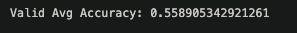

## Classifier Test
* This is where we run our classifier test

In [ ]:
# When Sonja and I were working seperately, this is where I consolidated our scores for
# Experimentation purposes
# Getting hardness scores from test csv
predictions = pd.read_csv('output_final_b.csv')

In [ ]:
# Prepping Test Predictions Raw Dataset
test_class_df = test_prompts.copy()

In [ ]:
# Pairing a prompt embedding with cluster labels for the purpose of 
# Assigning cluster labels to the test data set
prompt_clusters = class_df[['prompt_embedding', 'cluster_labels']]

In [ ]:
# Clustering Code via Sonja
# Assign test data to prompt clusters

# get cluster centroids (using df since that's what we used for the clustering)
df_sorted = prompt_clusters.sort_values(by='cluster_labels')
df_cen = df_sorted.groupby('cluster_labels')['prompt_embedding'].mean().rename('prompt_centroids')

# assigns an embedding to a cluster by smallest Euclidean distance
def assign_to_cluster(x):
  dist = []
  for i in range(len(df_cen)):
    distance = np.linalg.norm(x - df_cen.iloc[i])
    dist.append(distance)
  return np.argmin(dist)

# assign
test_class_df['prompt_embeddings'] = list(test_prompt_embeddings)
test_class_df['cluster_labels'] = test_class_df['prompt_embeddings'].apply(lambda x: assign_to_cluster(x))

In [ ]:
# Modified Identical Indicator Assignment function to accomodate for differently named columns in test set
def ifIdenticalTest(se):
    if se['model_a_response'] == se['model_b_response']:
        return 1
    else:
        return 0

In [ ]:
# Crafting a preprocessing function to return a transformed X_test
def classPreprocess(df, test_reduced_embeddings, preds, ra_embed, rb_embed, tp_embed): # preds is temporary
    # ignore warnings
    warnings.simplefilter('ignore')
    
    # Extract prompts and prompt lengths
    df["prompt_length"] = df["prompt"].str.len()
    df["response_a_length"] = df["model_a_response"].str.len()
    df["response_b_length"] = df["model_b_response"].str.len()
    df['response_length_difference'] = np.absolute(df['response_a_length'] - df['response_b_length'])
    
    # assign BT scores
    df = btAllocate(df, bt_model_skill_levels.to_dict())

    # Create Indicator Variables
    df['identical_indicator'] = df[['model_a_response', 'model_b_response']].apply(ifIdenticalTest, axis=1)

    # Generate Similarity Scores 
    ra_similarities = cosine_similarity(ra_embed, tp_embed)
    rb_similarities = cosine_similarity(rb_embed, tp_embed)
    r_similarities = cosine_similarity(ra_embed, rb_embed)
        
    # Add Hardness Scores from Sonja's Predictions
    df['hardness_score'] = preds['hardness_score']
    
    # Fixing skew with transforms
    df['log_prompt_length'] = np.log(df['prompt_length'])
    df['cube_a_length'] = np.cbrt(df['response_a_length'])
    df['cube_b_length'] = np.cbrt(df['response_b_length'])
    df['res_sim_cubed'] = (r_similarities.diagonal())**3
    df['log_bt_a'] = np.log(df['model_a_skill'])
    df['log_bt_b'] = np.log(df['model_b_skill'])
    df['rpSim_a_cubed'] = (ra_similarities.diagonal())**3
    df['rpSim_b_cubed'] = (rb_similarities.diagonal())**3
    
    preprocessor = make_column_transformer(
        (OneHotEncoder(), ['cluster_labels']),
        remainder = 'passthrough' # this leaves all other columns intact (no transformations done)
    )
   
    
    cluster_X = df[['cube_a_length', 'cube_b_length', 'log_prompt_length', 
          'res_sim_cubed', 'log_bt_a', 'log_bt_b', 'hardness_score', 'rpSim_b_cubed',
         'rpSim_a_cubed', 'identical_indicator', 'cluster_labels']]
    
    # Add Test Topic Embeddings
    for i in range(test_reduced_embeddings.shape[1]):
        cluster_X[f'topic_dim_{i}'] = test_reduced_embeddings[:, i]
    print(cluster_X.shape)
    # Preprocessing
    X_test = preprocessor.fit_transform(cluster_X)

    
    return X_test

In [ ]:
true_X_test = classPreprocess(test_class_df, test_topic_embeddings, predictions, test_response_a_embeddings,
                             test_response_b_embeddings, test_prompt_embeddings)

In [ ]:
# Generate Predictions
def predictLabels(X_and_y, true_X_test):
    """
    Generates predictions
    and returns confusion matrix
    """
    preprocessor = make_column_transformer(
        (OneHotEncoder(), ['cluster_labels']),
        remainder = 'passthrough' # this leaves all other columns intact (no transformations done)
    )
    # y_obs preprocess
    le = LabelEncoder()
    

    X_train_local = X_and_y[['cube_a_length', 'cube_b_length', 'log_prompt_length', 
          'res_sim_cubed', 'log_bt_a', 'log_bt_b', 'hardness_score', 'rpSim_b_cubed',
         'rpSim_a_cubed', 'identical_indicator', 'cluster_labels', 'topic_dim_0', 'topic_dim_1', 'topic_dim_2', 'topic_dim_3',
                         'topic_dim_4', 'topic_dim_5', 'topic_dim_6', 'topic_dim_7',
                         'topic_dim_8', 'topic_dim_9']]

    y_train_local = le.fit_transform(X_and_y['winner'])


    # Preprocessing
    X_train_transformed_local = preprocessor.fit_transform(X_train_local)

    clf = LogisticRegression(random_state=42,
                             solver='saga',
                             penalty='l1',
                             C=0.23713737056616552,
                             max_iter=4000,
                            fit_intercept=True)

    clf.fit(X_train_transformed_local, y_train_local)

    class_predictions = clf.predict(true_X_test)
    train_predictions = clf.predict(X_train_transformed_local)
    conf_matrix = confusion_matrix(y_train_local, train_predictions)
    
    return class_predictions, conf_matrix

### Assigning Predictions
* Generate predictions, assign them, and then create a confusion matrix
* Mainly used when Sonja and I were working on seperate notebooks to consolidate our answers

In [ ]:
class_predictions, conf_matrix = predictLabels(train_data, true_X_test)

In [ ]:
# Assign class predictions to predictions df (relic from working seperately)
# predictions['winner'] = class_predictions
# predictions['winner'] = predictions['winner'].map({0:'model_a', 1:'model_b',2:'tie',3:'tie (bothbad)'})

In [ ]:
# Export to CSV
# predictions.to_csv('output_final_b_complete.csv', index=False)

In [ ]:
### Create Confusion Matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
labels = ['Model_A', 'Model_B', 'Tie', 'Tie (BothBad)']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
# cmap = plt.get_cmap('Blues')
# plt.set_cmap(cmap)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Winner')
plt.ylabel('True Winner')

# **Task B**

# Some feature engineering

In [ ]:
# Some data cleaning and feature engineering

# Extract topics from salvagable null rows:
score_regex = r'\"score_value\":\s(\d)+'

# Salvagable raw choices used above in topic_extraction
salvagable_raw_choices = salvagable_null_rows.loc[:,'openai_scores_raw_choices_nested'].astype('str')
salvagable_raw_scores = salvagable_raw_choices.str.findall(pat=score_regex)

# Converting strings to ints then taking means
for index in salvagable_raw_scores.index:
    salvagable_raw_scores[index] = [int(item) for item in salvagable_raw_scores[index]]
    salvagable_raw_scores[index] = np.mean(salvagable_raw_scores[index])

# Save average hardness scores as series
salvagable_raw_scores.name = 'avg_hardness_score'
salvagable_null_rows['avg_hardness_score'] = salvagable_raw_scores

# Get average hardness scores of main data frame
topic_and_hardness['avg_hardness_score'] = (topic_and_hardness['score_value_1'] + topic_and_hardness['score_value_2'] + topic_and_hardness['score_value_3']) / 3

# Copy t & h into new df to avoid colab issues
topic_and_hardness_b = pd.concat([topic_and_hardness, salvagable_null_rows])
topic_and_hardness_b = topic_and_hardness_b.sort_index()

In [ ]:
# Get prompt features related to length
topic_and_hardness_b["prompt_length"] = topic_and_hardness_b["prompt"].str.len()
topic_and_hardness_b["Log prompt_length"] = topic_and_hardness_b["prompt_length"].apply(lambda x: np.log(x))

# Prompt word counts
topic_and_hardness_b['prompt_wc'] = topic_and_hardness_b['prompt'].str.split().str.len()
topic_and_hardness_b["Log prompt_wc"] = topic_and_hardness_b["prompt_wc"].apply(lambda x: np.log(x))

# response lengths
df_response_length = df[['question_id', "model_a_response_length", "model_b_response_length"]]

topic_and_hardness_b = pd.merge(topic_and_hardness_b, df_response_length, on='question_id', how='left')
topic_and_hardness_b["Log model_a_response_length"] = topic_and_hardness_b["model_a_response_length"].apply(lambda x: np.log(x))

## K-means clustering for prompt embeddings

---



In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import warnings

# Gonna do k-means on the non-duplicate rows
prompt_embeddings_no_dupes = np.delete(prompt_embeddings, dropped_indices, axis=0)

# save prompt embeddings to 2D matrix for k-means
matrix = np.stack(df['prompt_embedding'].to_numpy())

# Clustering embeddings
k = 50
k_means = KMeans(n_clusters=k,
               random_state=42)
cluster_labels = k_means.fit_predict(matrix)

# save cluster labels as series
df['prompt_embedding_cluster'] = cluster_labels
df2 = df[['question_id','prompt_embedding','prompt_embedding_cluster']]

# merge cluster labels with t & h
topic_and_hardness_b = pd.merge(topic_and_hardness_b, df2, on='question_id', how='left')

## Helper Functions

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# One-hot-encoding function
def ohe_wall_material(data, label):
    """
    One-hot-encodes a column.
    """
    new_data = data.copy(deep=True)

    encoder = OneHotEncoder(sparse_output=False)

    ohe = encoder.fit_transform(new_data[[label]])

    encoded_df = pd.DataFrame(ohe, columns=encoder.categories_[0])

    encoded_df.index = new_data.index

    new_data = pd.concat([new_data, encoded_df], axis=1)

    # Rename columns
    original_columns = new_data[label].unique()
    rename_dict = {col: label + '_' + str(col) for col in original_columns}
    new_data = new_data.rename(columns=rename_dict)

    return new_data


In [ ]:
# OHE the prompt embedding cluster labels
topic_and_hardness_b = ohe_wall_material(topic_and_hardness_b, 'prompt_embedding_cluster')


### More EDA for random features

In [ ]:
# Get the number of question marks?
topic_and_hardness_b['num_?'] = topic_and_hardness_b['prompt'].str.count(r'\?')

# Whether or not prompt contains one or more question marks
topic_and_hardness_b["contain_?"] = topic_and_hardness_b['num_?'].map(lambda x: '1' if x > 0 else '0')

# OHE
topic_and_hardness_b = ohe_wall_material(topic_and_hardness_b, 'contain_?')

# Getting prompt sentiments with the DistilBERT model

This took about 40 mins to run so I will provide the csv file with the data instead

In [ ]:
#from transformers import pipeline
#model_checkpoint = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
#model_checkpoint = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"

# Load the model
#sentiment_analysis = pipeline("sentiment-analysis", model=model_checkpoint, truncation=True)

def get_sentiment_abs(x):
  sentiment = sentiment_analysis(x)
  score = sentiment[0]['score']
  if sentiment[0]['label'] == 'negative':
    score *= -1.0
  return score

#topic_and_hardness_b['sentiment_abs'] = topic_and_hardness_b['prompt'].apply(lambda x: get_sentiment_abs(x))

In [ ]:
#df_sentiment = topic_and_hardness_b[['question_id','prompt','sentiment_abs']]

# Save to CSV
#df_sentiment.to_csv('sentiment.csv', index=False)

In [ ]:
# read sentiment csv

df_read_sentiment = pd.read_csv('sentiment_raw_pos_neg.csv', usecols=['question_id', 'sentiment_squared'])

topic_and_hardness_b = pd.merge(topic_and_hardness_b, df_read_sentiment, on='question_id', how='left')

In [ ]:
# Get absolute value of sentiment
topic_and_hardness_b['sentiment_abs'] = topic_and_hardness_b['sentiment_squared'].apply(lambda x: abs(x))

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(topic_and_hardness_b['sentiment_abs'], kde=True)
plt.title('Distribution of Absolute Sentiment Values')
plt.show()

# Subjectivity with TextBlob

In [ ]:
from textblob import TextBlob

def get_subjectivity(x):
  blob = TextBlob(x)
  return blob.sentiment.subjectivity

topic_and_hardness_b['prompt_subjectivity'] = topic_and_hardness_b['prompt'].apply(lambda x: get_subjectivity(x))

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(topic_and_hardness_b['prompt_subjectivity'], kde=True)
plt.title('Distribution of Prompt Subjectivity Values')
plt.show()

In [ ]:
topic_and_hardness_b['prompt_subjectivity'].describe()

In [ ]:
df_subjectivity = topic_and_hardness_b[['question_id','prompt','prompt_subjectivity']]

# Save to CSV
df_subjectivity.to_csv('subjectivity.csv', float_format='%.10f', index=False)

# Topic data

In [ ]:
# Store each of the 10 topic embedding dimensions as its own column
for i in range(train_topic_embeddings.shape[1]):
    topic_and_hardness_b[f'topic_dim_{i}'] = train_topic_embeddings[:, i]

topic_and_hardness_b["topic_embedding"] = list(train_topic_embeddings)

# Turning model A and B embeddings into features

In [ ]:
# Making model A response embeddings a feature

topic_and_hardness_b = pd.merge(topic_and_hardness_b, df[['question_id', "model_a_response_embedding"]], on='question_id', how='left')
array_2d = np.stack(topic_and_hardness_b["model_a_response_embedding"].values)

df_expanded = pd.DataFrame(array_2d)

df_expanded.columns = [f'model_a_dim_{i}' for i in range(256)]

original_index = topic_and_hardness_b.index
topic_and_hardness_b = pd.concat([topic_and_hardness_b.reset_index(drop=True), df_expanded.reset_index(drop=True)], axis=1)
topic_and_hardness_b.index = original_index

In [ ]:
# Do the same for Model B
topic_and_hardness_b = pd.merge(topic_and_hardness_b, df[['question_id', "model_b_response_embedding"]], on='question_id', how='left')
array_2d = np.stack(topic_and_hardness_b["model_b_response_embedding"].values)

df_expanded = pd.DataFrame(array_2d)

df_expanded.columns = [f'model_b_dim_{i}' for i in range(256)]

original_index = topic_and_hardness_b.index
topic_and_hardness_b = pd.concat([topic_and_hardness_b.reset_index(drop=True), df_expanded.reset_index(drop=True)], axis=1)
topic_and_hardness_b.index = original_index


## Looking at Correlations of features

In [ ]:
dfc = topic_and_hardness_b[['avg_hardness_score', 'Log prompt_length', 'Log prompt_wc', 'contain_?', "model_a_response_length", 'sentiment_abs', 'prompt_subjectivity']]#,'problem solving']]

corr_df = dfc.corr()

sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f')

plt.title("Pearson Pairwise Correlation")
plt.show()

# Building OLS model (no regularization)

In [ ]:
# Helper functions

from sklearn import linear_model as lm

# RMSE loss function
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

# training data splitting function
def train_val_split(data, split=0.8):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    train_ind = shuffled_indices[:int(split*data_len)]
    validation_ind = shuffled_indices[int(split*data_len):]
    train = data.iloc[train_ind]
    validation = data.iloc[validation_ind]

    return train, validation

In [ ]:
# Hand-pick features here! Using prompt embedding cluster, log prompt length,
# topic embeddings, and model a response embeddings

# Split training data
train, validation = train_val_split(topic_and_hardness_b, 0.99)

PE_columns = train['prompt_embedding_cluster'].unique()
PE_columns = ['prompt_embedding_cluster_' + str(num) for num in PE_columns]

PE_columns.append('Log prompt_length')

T_columns = ['topic_dim_' + str(num) for num in range(10)]
PE_columns.extend(T_columns)

RA_columns = ['model_a_dim_' + str(num) for num in range(256)]
PE_columns.extend(RA_columns)

RB_columns = ['model_b_dim_' + str(num) for num in range(256)]

features = PE_columns

print("Features chosen for LR:\n", features)

In [ ]:
# Instantiate LR model
np.random.seed(4242)

model = lm.LinearRegression(fit_intercept=True)

# get training data
X_train = train[features]
Y_train = train["avg_hardness_score"]

# get validation data
X_valid = validation[PE_columns]
Y_valid = validation["avg_hardness_score"]

# Fit training data
model.fit(X_train, Y_train)

# Predict training X
Y_fitted = model.predict(X_train)

# Predict validation data
Y_predicted = model.predict(X_valid)

In [ ]:
# Evaluate model performance

print("RMSE for training data: ", rmse(Y_train, Y_fitted))
print("RMSE for validation data: ", rmse(Y_valid, Y_predicted))

Y_predicted_rounded = np.round(Y_predicted).astype(int)
print("RMSE for rounded validation data: ", rmse(Y_valid, Y_predicted_rounded))
print()

Y_fitted_rounded = np.round(Y_fitted).astype(int)
Y_fitted_s = pd.Series(Y_fitted_rounded.reshape(-1))
print("Rounded fitted Y data:\n")
print(Y_fitted_s.value_counts())

print()
Y_predicted_rounded_s = pd.Series(Y_predicted_rounded.reshape(-1))
print("Rounded predicted Y data:\n")
print(Y_predicted_rounded_s.value_counts())

# Get coefficients
#print("Coefficients:", model.coef_)
#print("Intercept:", model.intercept_)

# Print coefficients with features names in descending order of magnitude
coef_df = pd.DataFrame(model.coef_.reshape(-1), index=X_train.columns)
coef_df.rename(columns={0: 'coefficient'}, inplace=True)
coef_df_sorted = coef_df.sort_values(by = 'coefficient', key=abs, ascending=False)

print()
print("Coefficients, sorted in descending order of abs:\n")
coef_df_sorted

# Cross-Validation

In [ ]:
from sklearn.model_selection import KFold

np.random.seed(4242)

# CV function
def compute_CV_error(X_train, Y_train, folds=10):
    model = lm.LinearRegression(fit_intercept=True)
    kf = KFold(n_splits=folds)
    validation_errors = []

    for train_idx, valid_idx in kf.split(X_train):
        # Split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        split_Y_valid_pred = model.predict(split_X_valid)

        # Compute the RMSE on the validation split
        error = rmse(split_Y_valid_pred, split_Y_valid)

        validation_errors.append(error)

    return validation_errors

cv = compute_CV_error(X_train, Y_train, folds=4)
#print(f"4-fold cross validation RMSE errors: {cv}")
avg_cv = np.mean(cv)
print("Avg 4-fold CV RMSE: ", avg_cv)
std_cv = np.std(cv)
print("Std: ", std_cv)

## Look at topics of each cluster

In [ ]:
#print(topic_and_hardness_b[topic_and_hardness_b['prompt_embedding_cluster'] == 31].head(20))

## Cleaning up test data + categorizing prompt embeddings

In [ ]:
# Get features for test data

# prompt length
df_test["prompt_length"] = df_test["prompt"].str.len()
df_test["Log prompt_length"] = df_test["prompt_length"].apply(lambda x: np.log(x))

# prompt wc
df_test['prompt_wc'] = df_test['prompt'].str.split().str.len()
df_test["Log prompt_wc"] = df_test["prompt_wc"].apply(lambda x: np.log(x))

# question marks
df_test['num_?'] = df_test['prompt'].str.count(r'\?')
df_test["contain_?"] = df_test['num_?'].map(lambda x: '1' if x > 0 else '0')

# model a response length
test_prompts["model_a_response_length"] = test_prompts["model_a_response"].str.len()
df_test = pd.concat([df_test.reset_index(drop=True), test_prompts["model_a_response_length"].reset_index(drop=True)], axis=1)
df_test["Log model_a_response_length"] = df_test["model_a_response_length"].apply(lambda x: np.log(x))


In [ ]:
# Get model A embeddings as feature
df_test["model_a_response_embedding"] = list(test_response_a_embeddings)

array_2d_test = np.stack(df_test["model_a_response_embedding"].values)

df_expanded_test = pd.DataFrame(array_2d_test)

df_expanded_test.columns = [f'model_a_dim_{i}' for i in range(256)]

original_index_test = df_test.index
df_test = pd.concat([df_test.reset_index(drop=True), df_expanded_test.reset_index(drop=True)], axis=1)
df_test.index = original_index_test

In [ ]:
# Get model B embeddings as feature
df_test["model_b_response_embedding"] = list(test_response_b_embeddings)

array_2d_test = np.stack(df_test["model_b_response_embedding"].values)

df_expanded_test = pd.DataFrame(array_2d_test)

df_expanded_test.columns = [f'model_b_dim_{i}' for i in range(256)]

original_index_test = df_test.index
df_test = pd.concat([df_test.reset_index(drop=True), df_expanded_test.reset_index(drop=True)], axis=1)
df_test.index = original_index_test

In [ ]:
# Assign test data to prompt clusters

# get cluster centroids (using df since that's what we used for the clustering)
df_sorted = df.sort_values(by='prompt_embedding_cluster')
df_cen = df_sorted.groupby('prompt_embedding_cluster')['prompt_embedding'].mean().rename('prompt_centroids')

# assigns an embedding to a cluster by smallest Euclidean distance
def assign_to_cluster(x):
  dist = []
  for i in range(len(df_cen)):
    distance = np.linalg.norm(x - df_cen.iloc[i])
    dist.append(distance)
  return np.argmin(dist)

# assign
df_test['prompt_embeddings'] = list(test_prompt_embeddings)
df_test['prompt_embedding_cluster'] = df_test['prompt_embeddings'].apply(lambda x: assign_to_cluster(x))

# OHE the test prompt cluster labels
df_test = ohe_wall_material(df_test, 'prompt_embedding_cluster')

In [ ]:
# Do the same for the topic embeddings

for i in range(test_topic_embeddings.shape[1]):
    df_test[f'topic_dim_{i}'] = test_topic_embeddings[:, i]


In [ ]:
# Get sentiment for test data if we decide to use sentiments
#df_test['sentiment_abs'] = df_test['prompt'].apply(lambda x: get_sentiment_abs(x))

# Predicting the test set

In [ ]:
# Predict test data

X_test = df_test[features]
Y_test = model.predict(X_test)

# Round to get integer data
Y_test_rounded = np.round(Y_test).astype(int)

my_series = pd.Series(Y_test_rounded.reshape(-1))
print("Predict rounded Y data:\n")
print(my_series.value_counts())

# Write to csv file

In [ ]:
#question_id, winner, hardness_score

s1 = df_test['question_id']

# replace with real data
s2 = pd.Series(class_predictions, index=s1.index, name='winner')

s3 = pd.Series(Y_test_rounded.reshape(-1), name='hardness_score')

# Combine into a DataFrame
df_csv = pd.concat([s1, s2, s3], axis=1)

# Save to CSV
df_csv.to_csv('output.csv', index=False)

# XGBoost

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# get features
T_columns = ['topic_dim_' + str(num) for num in range(10)]
RA_columns = [f'model_a_dim_{i}' for i in range(256)]
T_columns.extend(RA_columns)

num_feat = T_columns
num_feat.append('Log prompt_length')

tot_feat = num_feat.copy()
tot_feat.append('prompt_embedding_cluster')

# get design matrix
X_train_2 = train[tot_feat]
Y_train_2 = train["avg_hardness_score"]

X_valid_2 = validation[tot_feat]
Y_valid_2 = validation["avg_hardness_score"]

# Column types
categorical_features = ['prompt_embedding_cluster']
numerical_features = num_feat

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# XGBoost model pipeline
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', n_estimators=50, reg_lambda=2, random_state=42))
])

# Fit model
model_xgb.fit(X_train_2, Y_train_2)

# Predict
Y_pred = model_xgb.predict(X_valid_2)


# Evaluate
rmse = np.sqrt(mean_squared_error(Y_valid_2, Y_pred))
print(f'RMSE: {rmse:.2f}')


In [ ]:
# CV function
def compute_CV_error_xgb(X_train, Y_train, folds=10):
    kf = KFold(n_splits=folds)
    validation_errors = []

    for train_idx, valid_idx in kf.split(X_train):
        # Split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Column types
        categorical_features = ['prompt_embedding_cluster']
        numerical_features = num_feat

        # Preprocessing pipeline
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(drop='first'), categorical_features)
            ]
        )
        '''
        # XGBoost model pipeline
        model_xgb_cv = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', XGBRegressor(objective='reg:squarederror', n_estimators=100, reg_lambda=1, max_depth=4, random_state=42))
        ])
        '''
        # XGBoost model pipeline
        model_xgb_cv = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', XGBRegressor(objective='reg:squarederror', max_depth=3, n_estimators=75, reg_lambda=1, random_state=42))
        ])


        # Fit the model on the training split
        model_xgb_cv.fit(split_X_train, split_Y_train)
        split_Y_valid_pred = model_xgb_cv.predict(split_X_valid)

        # Compute the RMSE on the validation split
        rmse = np.sqrt(mean_squared_error(split_Y_valid_pred, split_Y_valid))
        #error = rmse(split_Y_valid_pred, split_Y_valid)

        validation_errors.append(rmse)

    return validation_errors

cv = compute_CV_error_xgb(train[tot_feat], train["avg_hardness_score"], folds=5)
print(f"4-fold cross validation RMSE errors: {cv}")
avg_cv = np.mean(cv)
print("Avg 4-fold CV RMSE: ", avg_cv)
std_cv = np.std(cv)
print("Std: ", std_cv)

In [ ]:
# Grid Search for Predictions
# from sklearn.model_selection import GridSearchCV

# # Split into training and validation sets
# #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# train_grid, validation_grid = train_val_split(topic_and_hardness_b, 0.8)
# X_train = train_grid[tot_feat]
# Y_train = train_grid["avg_hardness_score"]

# # get validation data
# X_valid = validation_grid[tot_feat]
# Y_valid = validation_grid["avg_hardness_score"]

# # Define the model
# xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# # Set the hyperparameter grid to search over
# param_grid = {
#     'n_estimators': [50, 75, 100],  # Number of boosting rounds
#     'max_depth': [2, 3, 6],           # Max depth of trees
#     'reg_lambda': [1, 1.5],
#     'min_child_weight': [3, 5, 10],
# }
# '''
# param_grid = {
#     'n_estimators': [50, 100, 200],  # Number of boosting rounds
#     'max_depth': [3, 6, 9],           # Max depth of trees
#     'learning_rate': [0.01, 0.1, 0.2], # Learning rate (eta)
#     'subsample': [0.8, 1.0],          # Subsample ratio
#     'colsample_bytree': [0.7, 0.8, 1.0] # Fraction of features for each tree
# }
# '''
# # Set up the GridSearchCV
# grid_search = GridSearchCV(estimator=xgb_model,
#                            param_grid=param_grid,
#                            scoring='neg_mean_squared_error',
#                            cv=4,
#                            n_jobs=-1,
#                            verbose=1)

# # Fit the grid search to the data
# grid_search.fit(X_train, Y_train)

# # Print the best hyperparameters found
# print("Best hyperparameters found: ", grid_search.best_params_)

# # Predict using the best model
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_valid)

# # Evaluate performance (RMSE)
# rmse = np.sqrt(mean_squared_error(Y_valid, y_pred))
# print(f'RMSE: {rmse:.2f}')



## Now for test data

In [ ]:
X_test_2 = df_test[tot_feat]
Y_test_2 = model_xgb.predict(X_test_2)
Y_test_2 = np.round(Y_test_2).astype(int)

my_series_2 = pd.Series(Y_test_2.reshape(-1))
print("Predict rounded Y data:\n")
print(my_series_2.value_counts())

In [ ]:
s12 = df_test['question_id']

s22 = pd.Series(class_predictions, index=s12.index, name='winner')

s32 = pd.Series(Y_test_2.reshape(-1), name='hardness_score')

# Combine into a DataFrame
df_xgb_csv = pd.concat([s12, s22, s32], axis=1)

# Save to CSV
df_xgb_csv.to_csv('output_xgb.csv', index=False)

In [ ]:
#df_xgb_read = pd.read_csv('/content/drive/MyDrive/colab_notebooks/ds_200_gp/output_xgb_read.csv', usecols=['question_id', 'hardness_score'])

#df_xgb_read['hardness_score'].value_counts()